Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 9, 64)             192       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                12850     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51        
Total params: 13,093
Trainable params: 13,093
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
37/37 - 0s - loss: 0.0338 - val_loss: 0.0189
Epoch 2/40
37/37 - 0s - loss: 0.0198 - val_loss: 0.0142
Epo

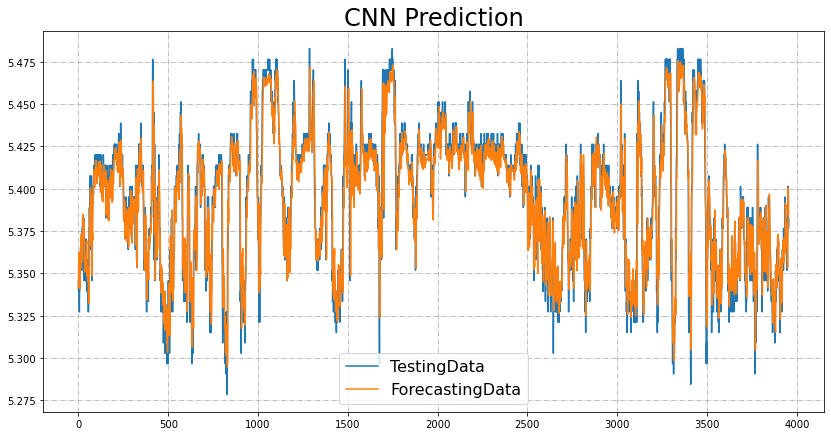

In [21]:
import math
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from pandas import read_excel, read_csv 

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,RepeatVector
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
from tensorflow.keras.models import load_model

plt.figure(figsize=(14,7))

#loading data
df = read_excel('.../channel_100.xlsx',usecols = [1],header = 0)
dataset = df.values
dataset = dataset.astype('float')
scaler = MinMaxScaler(feature_range = (-1,1))
dataset = scaler.fit_transform(dataset)

#create input
timestep = 10

X= []
Y=[]

raw_data=dataset

for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)

train_size = int(len(dataset) * 0.7)
Xtrain = X[:train_size,:,:]  
Ytrain = Y[:train_size] 
Xtest = X[train_size:,:,:]  
Ytest= Y[train_size:]  

#create and fit CNN network 
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(10, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
start = time.time()
hist = model.fit(Xtrain,Ytrain, validation_data = (Xtest, Ytest), epochs = 40,batch_size = 256,verbose = 2)
end = time.time()
print("Train time: %.4f" % (end-start))

trainPredict = model.predict(Xtrain)
trainPredict = scaler.inverse_transform(trainPredict)

testPredict = model.predict(Xtest)
testPredict = scaler.inverse_transform(testPredict)

Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)

MSE = mean_squared_error(Ytest,testPredict)
print('Test MSE: %.4f MSE' % (MSE))
MAE = mean_absolute_error(Ytest,testPredict)
print('Test MAE: %.4f MAE' % (MAE))
R2 = r2_score(Ytest,testPredict)
print('Test R2: %.4f R2' % (R2))

plt.title('CNN Prediction',fontsize = 24)
plt.plot(Ytest,label='TestingData')
plt.plot(testPredict,label='ForecastingData')
plt.legend(fontsize = 16)
plt.grid(linestyle='-.')
plt.show()
